In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, ReLU, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image
from IPython.display import clear_output

from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import time

%matplotlib inline

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
train_path = 'drive/MyDrive/Colab_Notebooks/Robot/figures'

In [11]:
img_size = (224, 224)
num_classes = 9
batch_size = 25

## Подготовка и аугментация данных

In [12]:
datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.1
)

In [ ]:
def augment_image(image,save_here, datagen, count=9):
  image = np.expand_dims(image, 0) 
  datagen.fit(image)
  image_generator = datagen.flow(np.array(image),save_to_dir=save_here, save_prefix='aug',save_format='png')
  for _ in range(count):
    image_generator.next()

In [ ]:
for category, path in enumerate(os.listdir(train_path)):
  dir_path = os.path.join(train_path,path)
  for image_path in os.listdir(dir_path):
    img = Image.open(os.path.join(dir_path,image_path))
    augment_image(img, dir_path, datagen)
  

In [13]:
train_generator = datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training',
    seed=42
)

validation_generator = datagen.flow_from_directory(
    train_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='validation',
    seed=42
)

Found 2050 images belonging to 9 classes.
Found 220 images belonging to 9 classes.


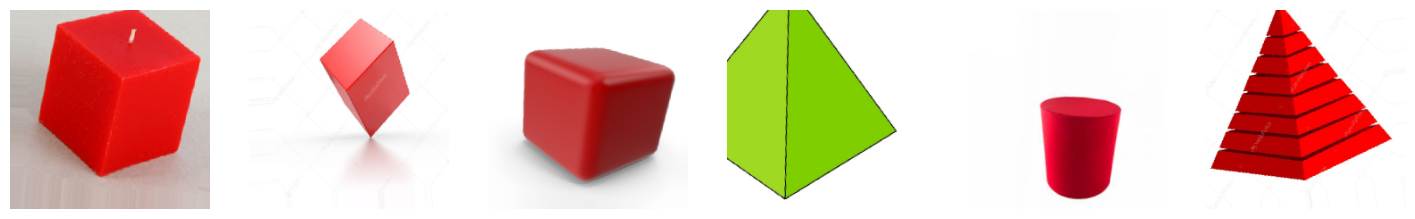

In [25]:
x = train_generator.next()[0]
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(x[i])

plt.show();

## VGG19

In [ ]:
def Conv_pulBL(inputs, 
               new_dim, 
               num, 
               kernel_size = (3, 3), 
               padding='same',
               pool_size = (2, 2), 
               stride = 2):

  """
  Функция создания блока Conv2D, Relu, MaxPooling2D
  
  Входные параметры:
        inputs - входной слой блока
        new_dim - размерность, в которую переводит слой Conv2D
        num  - количество используемых слоёв Conv2D
  """
  
  x = Conv2D(new_dim, kernel_size, padding=padding)(inputs)
  x = Conv2D(new_dim, kernel_size, padding=padding)(x)
  
  if num == 4:
    x = Conv2D(new_dim, kernel_size, padding=padding)(x)
    x = Conv2D(new_dim, kernel_size, padding=padding)(x)

  x = ReLU()(x)
  x = MaxPooling2D(pool_size, stride)(x)

  return x

In [ ]:

def create_VGG19(inputs, num_classes):
    """
    Функция создания модели VGG19
    
    Входные параметры:
        inputs - входной слой модели
        num_classes - количество классов
    """
    
    x = Conv_pulBL(inputs, 64, 2)
    x = Conv_pulBL(x, 128, 2)
    x = Conv_pulBL(x, 256, 4)
    x = Conv_pulBL(x, 512, 4)
    x = Conv_pulBL(x, 512, 4)
    x = Flatten()(x)
    x = Dense(4096, activation='relu')(x)
    x = Dense(4096, activation='relu')(x)
    x = Dense(num_classes, activation='softmax')(x)

    return Model(inputs, x), x

In [ ]:
def create_model(input_shape,
                num_classes,
                use_weights = False, 
                weights_path = 'vgg19.h5'):

  """
  Функция создания полной модели
  
  Входные параметры:       
    input_shape - размерность входного изображения для модели VGG19
    num_classes - количество классов   
    use_weights - использовать ли предобученные веса         
    weights_path - путь к сохраненным весам модели  
  """
  
  w, h = input_shape 
  inputs = Input(shape = (w, h, 3))

  y_true = 0

  model_vgg, outputs = create_VGG19(inputs, num_classes)
  print ('Создана модель VGG19. Количество классов: {}.'.format(num_classes))

  if use_weights:
        model_vgg.load_weights(weights_path, by_name = False, skip_mismatch = False) 
        print ('Загружены веса из файла {}.'.format(weights_path)) 

  return Model(inputs, outputs)
  

### Создание модели

In [ ]:
model_VGG = create_model(img_size, num_classes)

Создана модель VGG19. Количество классов: 9.


In [ ]:
model_VGG.summary()

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_144 (Conv2D)         (None, 224, 224, 64)      1792      
                                                                 
 conv2d_145 (Conv2D)         (None, 224, 224, 64)      36928     
                                                                 
 re_lu_45 (ReLU)             (None, 224, 224, 64)      0         
                                                                 
 max_pooling2d_45 (MaxPoolin  (None, 112, 112, 64)     0         
 g2D)                                                            
                                                                 
 conv2d_146 (Conv2D)         (None, 112, 112, 128)     73856     
                                                          

### Обучение модели

In [ ]:
lr_value = 1e-4 

model_VGG.compile(optimizer=Adam(learning_rate=lr_value),loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
startTime = time.time() 
model_filename = 'drive/MyDrive/Colab_Notebooks/Robot/weights/VGG/VGG19__el1000__opt0.0001__ep0_10.h5'

history = model_VGG.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs=10,
    verbose=1
)

model_VGG.save_weights(model_filename)

loss_1 = np.array(history.history['loss']) 
val_loss_1 = np.array(history.history['val_loss']) 
accuracy_1 = np.array(history.history['accuracy'])
val_accuracy_1 = np.array(history.history['val_accuracy'])

print ('Время обработки: '+ str(round(time.time() - startTime)) + 'сек') 

Epoch 1/10
82/82 [==============================] - 101s 1s/step - loss: 1.2723 - accuracy: 0.4273 - val_loss: 0.8739 - val_accuracy: 0.6100
Epoch 2/10
82/82 [==============================] - 92s 1s/step - loss: 0.8059 - accuracy: 0.6249 - val_loss: 0.7084 - val_accuracy: 0.6600
Epoch 3/10
82/82 [==============================] - 90s 1s/step - loss: 0.6852 - accuracy: 0.6888 - val_loss: 0.6475 - val_accuracy: 0.6900
Epoch 4/10
82/82 [==============================] - 91s 1s/step - loss: 0.7752 - accuracy: 0.6727 - val_loss: 0.4616 - val_accuracy: 0.7850
Epoch 5/10
82/82 [==============================] - 90s 1s/step - loss: 0.5034 - accuracy: 0.7912 - val_loss: 0.3908 - val_accuracy: 0.8350
Epoch 6/10
82/82 [==============================] - 89s 1s/step - loss: 0.4146 - accuracy: 0.8171 - val_loss: 0.4513 - val_accuracy: 0.8200
Epoch 7/10
82/82 [==============================] - 92s 1s/step - loss: 0.3750 - accuracy: 0.8400 - val_loss: 0.2491 - val_accuracy: 0.8900
Epoch 8/10
82/82 [=

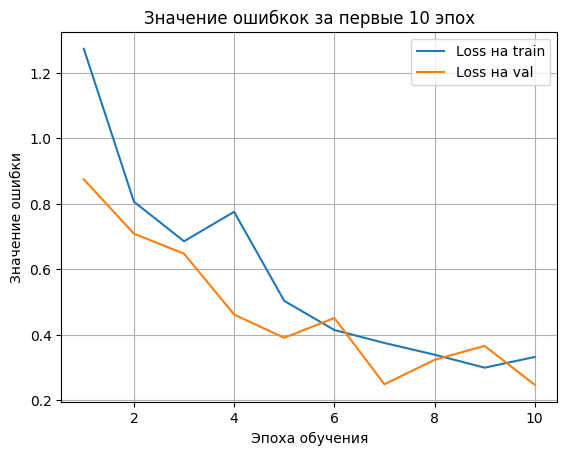

In [ ]:
epox = list(range(1, 11))

plt.plot(epox, loss_1, label='Loss на train')
plt.plot(epox, val_loss_1, label='Loss на val')
plt.title('Значение ошибкок за первые 10 эпох')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.grid()
plt.show()

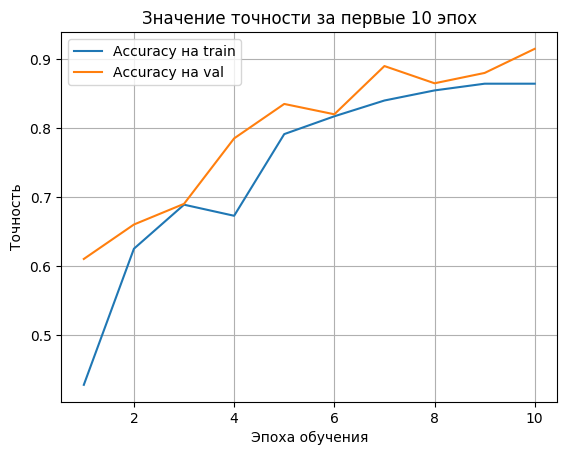

In [ ]:
plt.plot(epox, accuracy_1, label='Аccuracy на train')
plt.plot(epox, val_accuracy_1, label='Аccuracy на val')
plt.title('Значение точности за первые 10 эпох')
plt.xlabel('Эпоха обучения')
plt.ylabel('Точность')
plt.legend()
plt.grid()
plt.show()

In [ ]:
lr_value = 1e-5 

model_VGG.compile(optimizer=Adam(learning_rate=lr_value),loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
startTime = time.time() 
model_filename = 'drive/MyDrive/Colab_Notebooks/Robot/weights/VGG/VGG19__el1000__opt0.00001__ep0_10.h5'

history = model_VGG.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator, 
    validation_steps = validation_generator.samples // batch_size,
    epochs=10,
    verbose=1
)

model_VGG.save_weights(model_filename)

loss_2 = np.array(history.history['loss']) 
val_loss_2 = np.array(history.history['val_loss']) 
accuracy_2 = np.array(history.history['accuracy'])
val_accuracy_2 = np.array(history.history['val_accuracy'])

print ('Время обработки: '+ str(round(time.time() - startTime)) + 'сек') 

Epoch 1/10
82/82 [==============================] - 100s 1s/step - loss: 0.1981 - accuracy: 0.9068 - val_loss: 0.1801 - val_accuracy: 0.9200
Epoch 2/10
82/82 [==============================] - 91s 1s/step - loss: 0.1426 - accuracy: 0.9463 - val_loss: 0.1193 - val_accuracy: 0.9550
Epoch 3/10
82/82 [==============================] - 90s 1s/step - loss: 0.1266 - accuracy: 0.9459 - val_loss: 0.1363 - val_accuracy: 0.9550
Epoch 4/10
82/82 [==============================] - 91s 1s/step - loss: 0.1099 - accuracy: 0.9615 - val_loss: 0.0903 - val_accuracy: 0.9600
Epoch 5/10
82/82 [==============================] - 91s 1s/step - loss: 0.0982 - accuracy: 0.9576 - val_loss: 0.1282 - val_accuracy: 0.9400
Epoch 6/10
82/82 [==============================] - 100s 1s/step - loss: 0.0974 - accuracy: 0.9585 - val_loss: 0.0879 - val_accuracy: 0.9700
Epoch 7/10
82/82 [==============================] - 111s 1s/step - loss: 0.0817 - accuracy: 0.9678 - val_loss: 0.1194 - val_accuracy: 0.9600
Epoch 8/10
82/82 

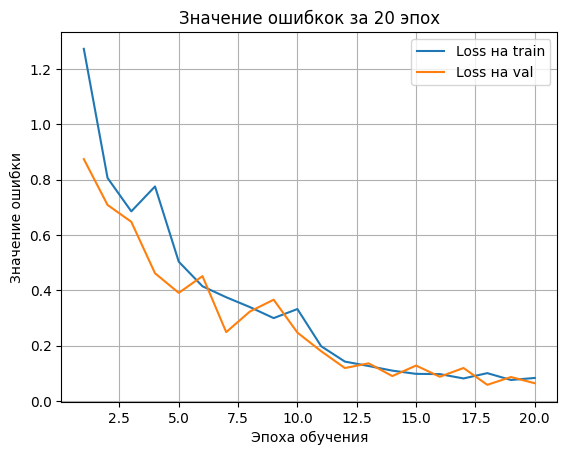

In [ ]:
epox_2 = list(range(1, 21))
loss = np.append(loss_1.copy(), loss_2)
val_loss = np.append(val_loss_1.copy(), val_loss_2)

plt.plot(epox_2, loss, label='Loss на train')
plt.plot(epox_2, val_loss, label='Loss на val')
plt.title('Значение ошибкок за 20 эпох')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.grid()
plt.show()

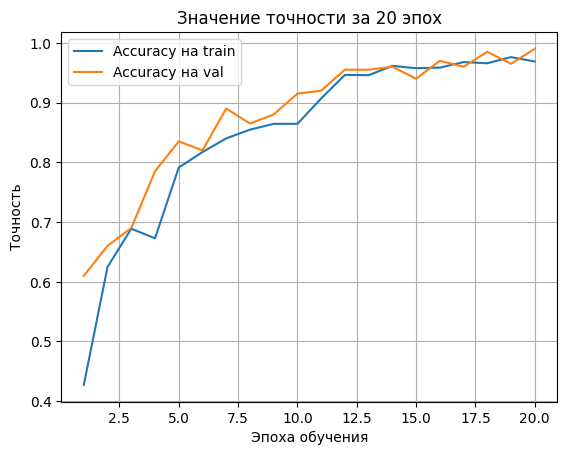

In [ ]:
accuracy = np.append(accuracy_1.copy(), accuracy_2)
val_accuracy = np.append(val_accuracy_1.copy(), val_accuracy_2)

plt.plot(epox_2, accuracy, label='Accuracy на train')
plt.plot(epox_2, val_accuracy, label='Accuracy на val')
plt.title('Значение точности за 20 эпох')
plt.xlabel('Эпоха обучения')
plt.ylabel('Точность')
plt.legend()
plt.grid()
plt.show()